In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import IPython
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

# POUR LA MORPHO
#from skimage.morphology import watershed 
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max



In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=True  # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





Loading BokehJS ...

In [8]:
#%% fonction pour voir une image




# def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
#     """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
#         dans gimp. Si un gimp est deja ouvert il est utilise.
#         Par defaut normalise=True. Et dans ce cas l'image est normalisee 
#         entre 0 et 255 avant d'être sauvegardee.
#         Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
#     """
#     imt=np.float32(im.copy())
#     if platform.system()=='Darwin': #on est sous mac
#         prephrase='open -a /Applications/GIMP.app '
#         endphrase=' &' 
#     elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
#         prephrase='gimp -a '
#         endphrase= ' &'
#     elif platform.system()=='Windows':
#         prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
#         endphrase= ''
#     else:
#         print('Systeme non pris en charge par l affichage GIMP')
#         return 'erreur d afficahge'
    
#     if normalise:
#         m=imt.min()
#         imt=imt-m
#         M=imt.max()
#         if M>0:
#             imt=imt/M

#     else:
#         imt=(imt-MINI)/(MAXI-MINI)
#         imt[imt<0]=0
#         imt[imt>1]=1
    
#     if titre!='':
#         titre='_'+titre+'_'
#     nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
#     commande=prephrase +nomfichier+endphrase
#     skio.imsave(nomfichier,imt)
#     os.system(commande)

def viewimage(im, normalize=True, titre='', displayfilename=False):
        imin = im.copy().astype(np.float32)
    
        if normalize:
            imin -= imin.min()
    
        if imin.max() > 0:
            imin /= imin.max()
        else:
            imin = imin.clip(0, 255) / 255

        imin = (imin * 255).astype(np.uint8)
        filename = tempfile.mktemp(titre + '.png')
    
        if displayfilename:
            print(filename)
    
        plt.imsave(filename, imin, cmap='gray')
        IPython.display.display(IPython.display.Image(filename))

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    
    # def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
    #     img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
    #     p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    #     p.x_range.range_padding = p.y_range.range_padding = 0

    #     # must give a vector of images
    #     p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    #     showbokeh(p)

    #FONCTION viewimage universelle

    # FONCTION viewimage universelle

    def viewimage(im, normalize=True, titre='', displayfilename=False):
        imin = im.copy().astype(np.float32)
    
        if normalize:
            imin -= imin.min()
    
        if imin.max() > 0:
            imin /= imin.max()
        else:
            imin = imin.clip(0, 255) / 255

        imin = (imin * 255).astype(np.uint8)
        filename = tempfile.mktemp(titre + '.png')
    
        if displayfilename:
            print(filename)
    
        plt.imsave(filename, imin, cmap='gray')
        IPython.display.display(IPython.display.Image(filename))



  


In [9]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(complex)(np.zeros((sy,sx)))
    denom=np.vectorize(complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [10]:
#%% lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



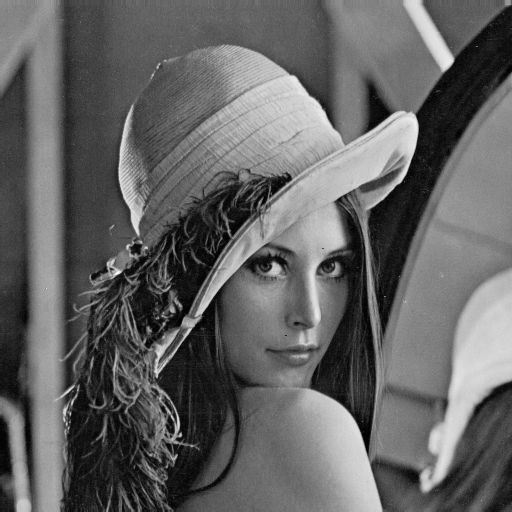

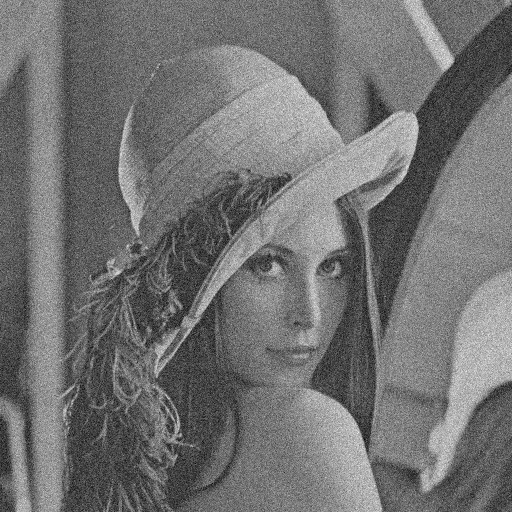

In [11]:
#%%

# voir l'image
viewimage(im,titre='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
viewimage(imb,titre='BRUITEE')



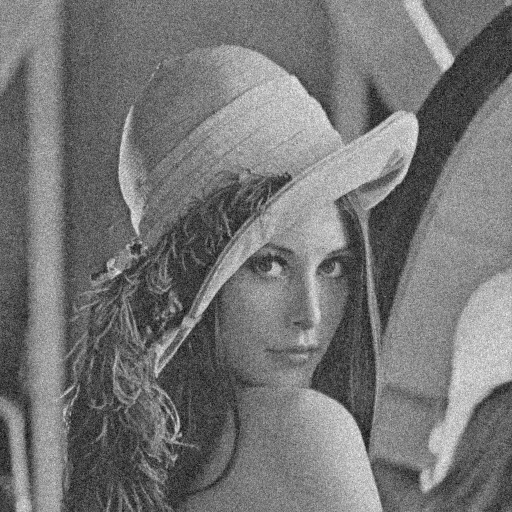

In [19]:
#%% restauration quadratique : exemple
lamb=0.1
restau=minimisation_quadratique(imb,lamb)
viewimage(restau,titre='RESTQUAD_LAMB='+str(lamb))



0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


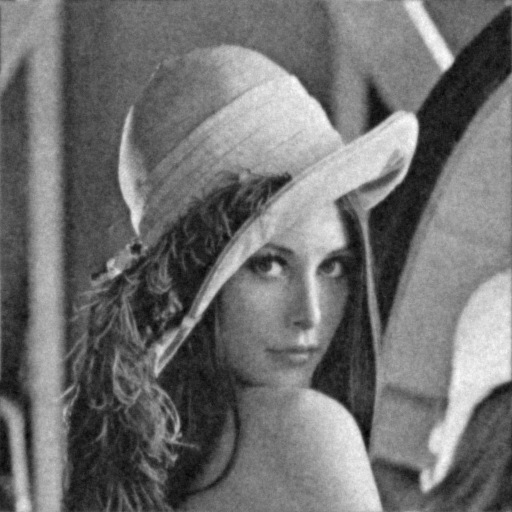

In [24]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01)
for k in vk: 
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    


#plt.plot(10**vk,errvt);
viewimage(restq,titre='')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


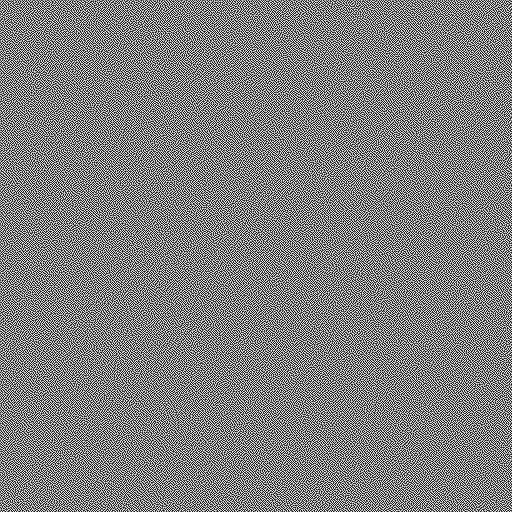

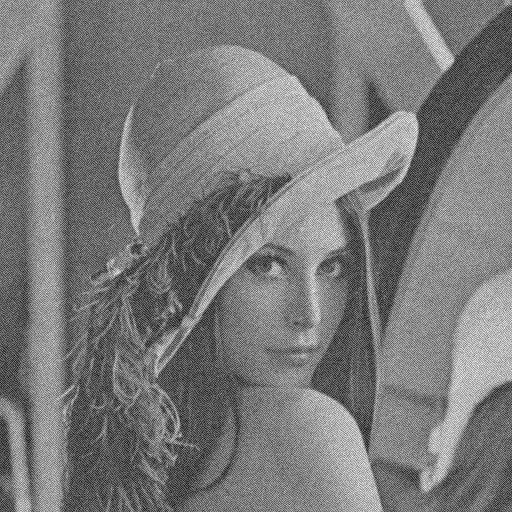

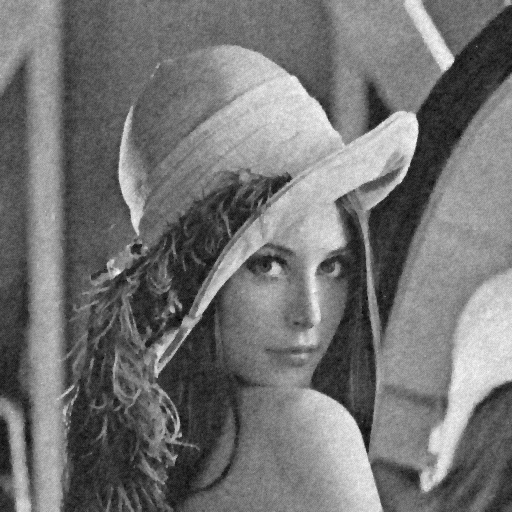

In [29]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)
viewimage(u1,titre='pas = 1')
viewimage(u05,titre='pas = 0.5')
viewimage(u01,titre='pas = 0.1')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


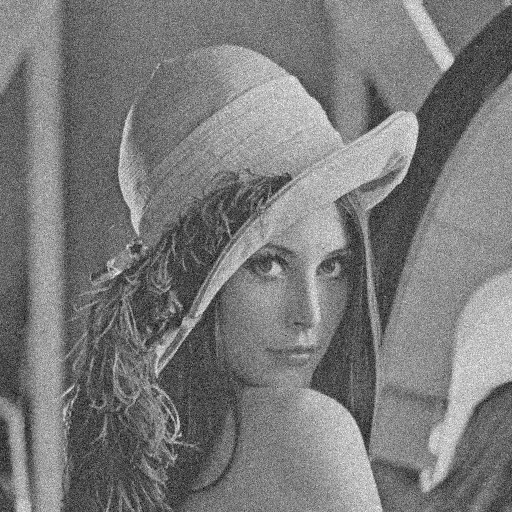

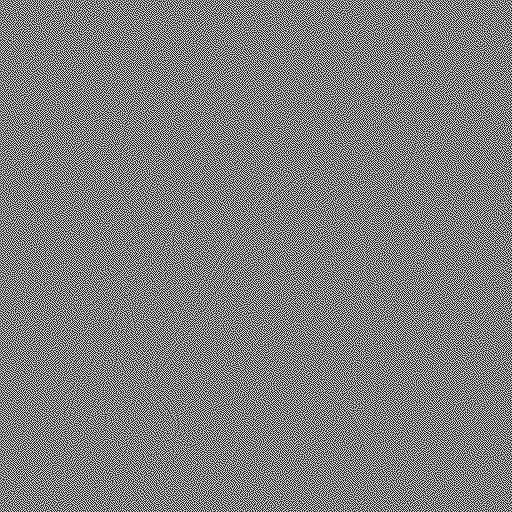

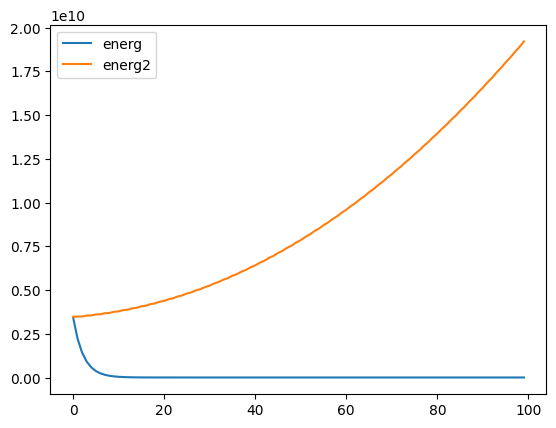

In [30]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u2,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ,label='energ')
plt.plot(energ2,label='energ2')
plt.legend()

viewimage(u,titre='pas = 0.1')
viewimage(u2,titre='pas = 1')


## 1 Débruitage par régularisation quadratique 

1. On décompose l'énergie comme la somme de terme de la forme $||K_i * u - v_i ||^2$ :

$$E_1(u) = ||u-v||^2 + \lambda||\nabla(u)||^2 = || Id * u - v ||^2 + || K_x * u ||^2 + || K_y * u ||^2 $$

Puis on donne à la fonction **resoud_quad_fourier** $((Id,K_x,K_y),(v,0,0))$ comme argument.

2. Lorsque $\lambda$ est très grand, le terme d'attache aux données est négligeable devant le terme de régularisation, donc l'image qui minimiserait le terme $||\nabla(u)||$ est une image dont le gradient est nul, et donc elle est constante. Si $\lambda$ est petit, le terme d'attache aux données est le plus pesant est donc l'image qui minimise l'énergie devrait etre proche de l'image observée.

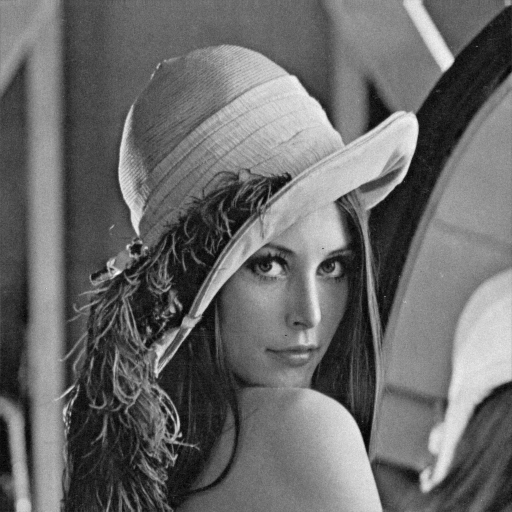

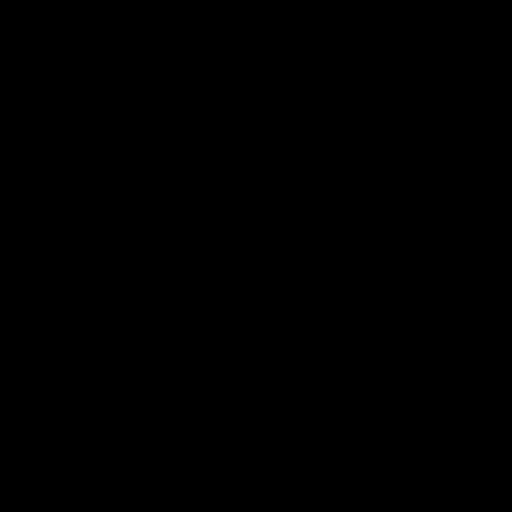

In [40]:
#1.2
imb = degrade_image(im,5)
u1 = minimisation_quadratique(imb,0.1)
u2 = minimisation_quadratique(imb,10000000000000)
viewimage(u1,titre="")
viewimage(u2,titre="")

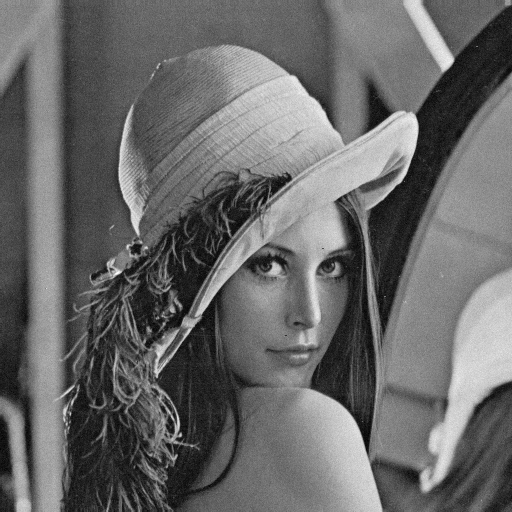

In [33]:
sigma = 5
imb = degrade_image(im,sigma)
viewimage(imb)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


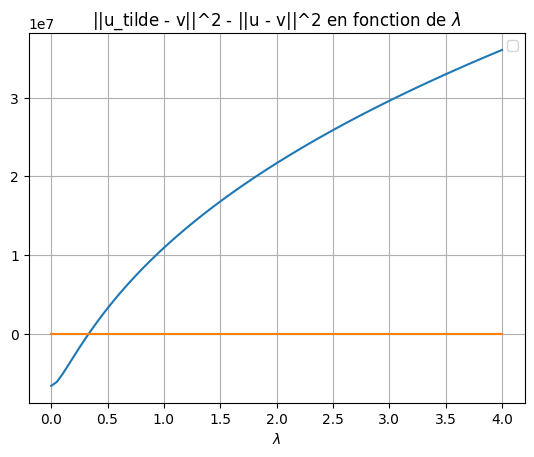

In [29]:
sigma = 5
imb = degrade_image(im,sigma)
lamda_tab = np.linspace(0,4,80)
erreur_tab = [norm2(minimisation_quadratique(imb,lamda) - imb )**2 - norm2(im - imb )**2  for lamda in lamda_tab]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(lamda_tab,erreur_tab)
ax.plot(lamda_tab,[0 for k in range(len(lamda_tab))])
ax.set_title(r'||u_tilde - v||^2 - ||u - v||^2 en fonction de $\lambda$')
ax.set_xlabel(r'$\lambda$')
ax.grid(True)
ax.legend()
plt.show()

0.3308183792978525


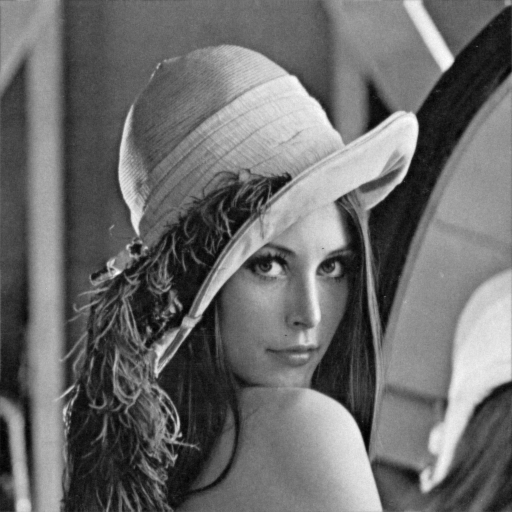

||u_tilde - v||^2 = 6551859.86420355
||u - v||^2 = 6551859.946634655
||u_tilde - v||^2 - ||u - v||^2 = -0.08243110496550798
||u_tilde - u||^2  =  12137982.583381895


In [56]:
#1.3
eps = 1e-8
sigma = 5
imb = degrade_image(im,sigma)

def f(lamda):
    u_tilde = minimisation_quadratique(imb,lamda)
    return norm2(u_tilde - imb )**2 - norm2(im - imb )**2

g = 0
d = 10
erreur = []
while d - g > eps:
    lamda = (g+d)/2
    if f(lamda)> 0:
            d = lamda
    else : 
            g = lamda

print(lamda)
u_tilde = minimisation_quadratique(imb,lamda)
viewimage(u_tilde,titre=str(lamda))
print('||u_tilde - v||^2 =',norm2(u_tilde - imb )**2)
print('||u - v||^2 =',norm2(im - imb )**2)
print('||u_tilde - v||^2 - ||u - v||^2 =',f(lamda))

erreur1 = norm2(minimisation_quadratique(u_tilde,lamda)-im)**2
print('||u_tilde - u||^2  = ', erreur1)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


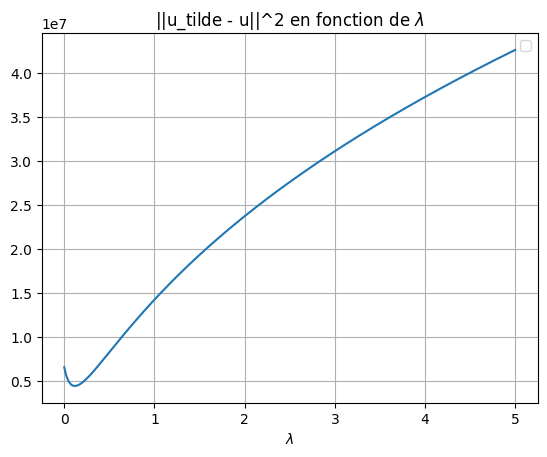

In [52]:
sigma = 5
imb = degrade_image(im,sigma)
lamda_tab = np.linspace(0,5,500)
erreur_tab = [norm2(minimisation_quadratique(imb,lamda) - im)**2 for lamda in lamda_tab]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(lamda_tab,erreur_tab)
ax.set_title(r'||u_tilde - u||^2 en fonction de $\lambda$')
ax.set_xlabel(r'$\lambda$')
ax.grid(True)
ax.legend()
plt.show()

0.11596678756177425


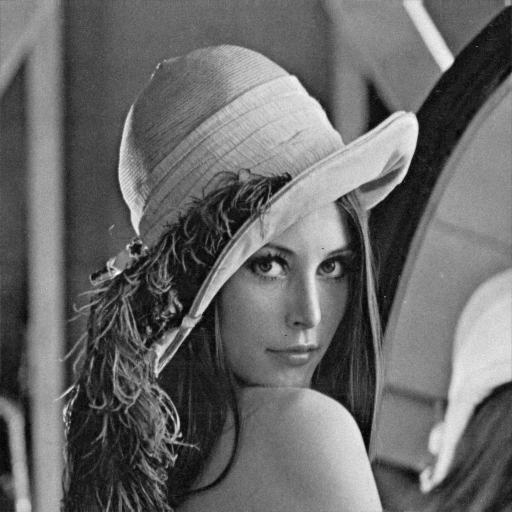

In [51]:
eps = 1e-8
g = 0
d = 5

def h(lamda):
    return norm2(minimisation_quadratique(imb,lamda) - im)**2

while d - g > eps:
    lamda = (g+d)/2
    if h(lamda) <= h(d):
            d = lamda
    else : 
            g = lamda

print(lamda)
viewimage(minimisation_quadratique(imb,lamda),titre=str(lamda))

In [55]:
erreur2 = norm2(minimisation_quadratique(imb,lamda)-im)**2
print('||u_tilde - u||^2  = ', erreur2)

||u_tilde - u||^2  =  4456768.168141144


In [57]:
print(erreur1/erreur2)

2.7234942733053304


## 2 Débruitage par variation totale

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


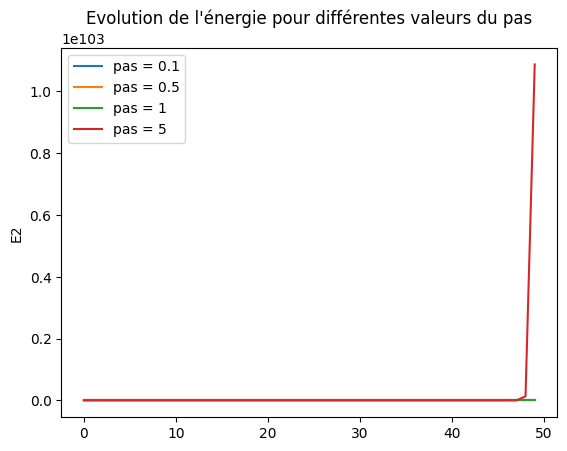

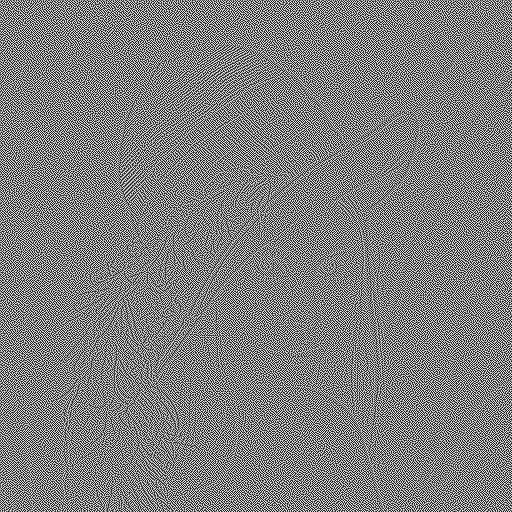

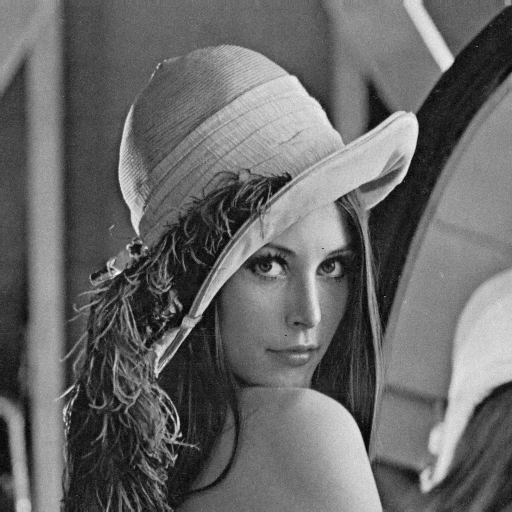

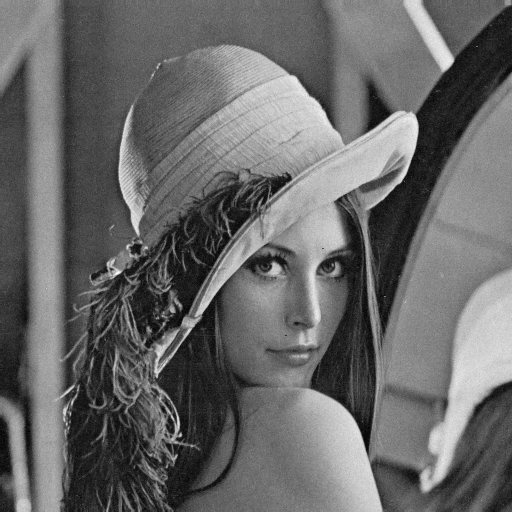

In [67]:
u01,en01=minimise_TV_gradient(imb, 1,0.1, 50)
u05,en05=minimise_TV_gradient(imb, 1, 0.5, 50)
u1,en1=minimise_TV_gradient(imb, 1, 1, 50)

plt.plot(en01,label='pas = 0.1')
plt.plot(en05,label='pas = 0.5')
plt.plot(en1,label='pas = 1')

plt.title("Evolution de l'énergie pour différentes valeurs du pas")
plt.ylabel('E2')
plt.legend()
plt.show()

viewimage(u1,titre='pas = 0.1')
viewimage(u05,titre='pas = 0.5')
viewimage(u01,titre='pas = 1')

C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:174: RuntimeWarning: divide by zero encountered in divide
  N=div(px,py)-I/a
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:32: RuntimeWarning: invalid value encountered in add
  M[:,:-1]=-I[:,:-1]+I[:,1:]
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:22: RuntimeWarning: invalid value encountered in add
  M[:-1,:]=-I[:-1,:]+I[1:,:]
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:178: RuntimeWarning: invalid value encountered in divide
  pxnew=(px+t*Gx)/(un+t*G)
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:179: RuntimeWarning: invalid value encountered in divide
  pynew=(py+t*Gy)/(un+t*G)


Meilleur lamdbda : 0.0


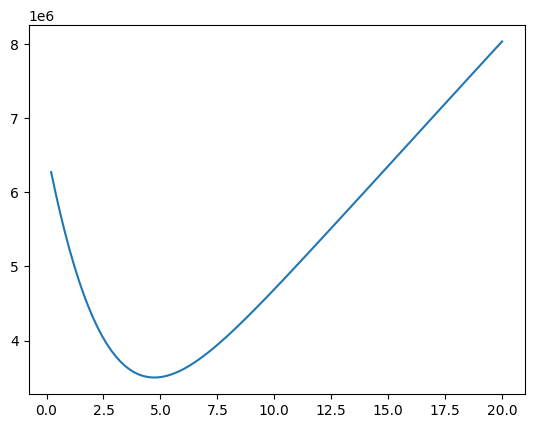

C:\Users\m\AppData\Local\Temp\ipykernel_22476\843756601.py:118: RuntimeWarning: invalid value encountered in cast
  imin = (imin * 255).astype(np.uint8)


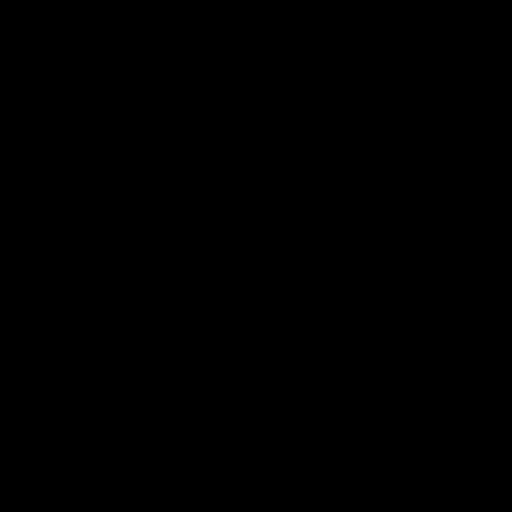

In [71]:
imb = degrade_image(im,5)
lamda_tab = np.linspace(0,20,100)
erreur_tab_chambolle = [norm2(vartotale_Chambolle(imb,lamda)-im)**2 for lamda in lamda_tab]
lamda_chambolle = lamda_tab[np.argmin(erreur_tab_chambolle)]
erreur_chambolle = np.min(erreur_tab_chambolle)
u_chambolle = vartotale_Chambolle(imb,lamda_chambolle)
print('Meilleur lamdbda :', lamda_chambolle)

plt.plot(lamda_tab, erreur_tab_chambolle)
plt.scatter(lamda_chambolle,erreur_chambolle)
plt.show()
viewimage(u_chambolle)

In [72]:
imb = degrade_image(im,25)

lamda quadratique 1.1718749906867743
erreur de la méthode quadratique : 28138685.363172133


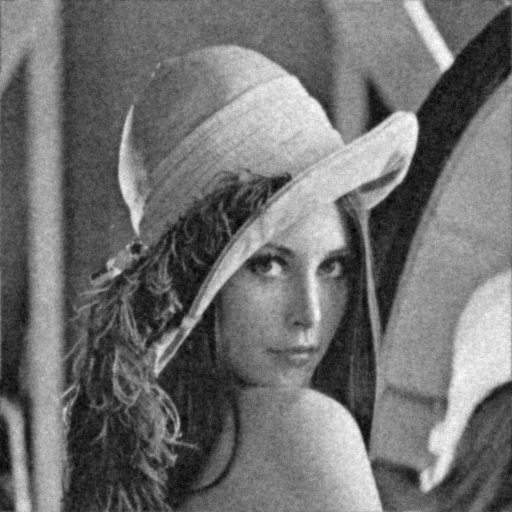

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


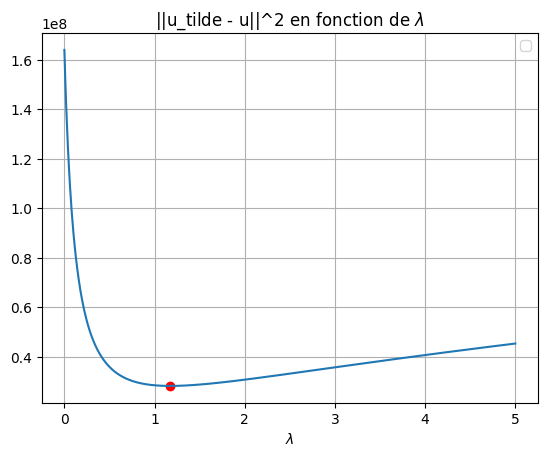

In [77]:
#QUADRATIQUE 

eps = 1e-8
g = 0
d = 5

def h(lamda):
    return norm2(minimisation_quadratique(imb,lamda) - im)**2

while d - g > eps:
    lamda = (g+d)/2
    if h(lamda) <= h(d):
            d = lamda
    else : 
            g = lamda

lamda_quadratique = lamda
print('lamda quadratique',lamda_quadratique)
u_quadratique = minimisation_quadratique(imb,lamda)
erreur_quad = norm2(u_quadratique-im)**2
print('erreur de la méthode quadratique :', erreur_quad)
viewimage(u_quadratique,titre=str(lamda))

lamda_tab_quad = np.linspace(0,5,500)
erreur_tab_quad = [norm2(minimisation_quadratique(imb,lamda) - im)**2 for lamda in lamda_tab_quad]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(lamda_tab_quad,erreur_tab_quad)
ax.set_title(r'||u_tilde - u||^2 en fonction de $\lambda$')
ax.set_xlabel(r'$\lambda$')
ax.scatter(lamda_quadratique,erreur_quad,c='r')
ax.grid(True)
ax.legend()

In [ ]:
#TV
eps = 1e-8
g = 0
d = 100

def h(lamda):
    return norm2(vartotale_Chambolle(imb,lamda) - im)**2

while d - g > eps:
    lamda = (g+d)/2
    if h(lamda) <= h(d):
            d = lamda
    else : 
            g = lamda

lamda_chambolle_dic = lamda
print('lamdbda chambolle dichotomie',lamda_chambolle_dic)



C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:174: RuntimeWarning: divide by zero encountered in divide
  N=div(px,py)-I/a
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:32: RuntimeWarning: invalid value encountered in add
  M[:,:-1]=-I[:,:-1]+I[:,1:]
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:22: RuntimeWarning: invalid value encountered in add
  M[:-1,:]=-I[:-1,:]+I[1:,:]
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:178: RuntimeWarning: invalid value encountered in divide
  pxnew=(px+t*Gx)/(un+t*G)
C:\Users\m\AppData\Local\Temp\ipykernel_22476\2348627174.py:179: RuntimeWarning: invalid value encountered in divide
  pynew=(py+t*Gy)/(un+t*G)


Meilleur lamdbda CHAMBOLLE : 0.0


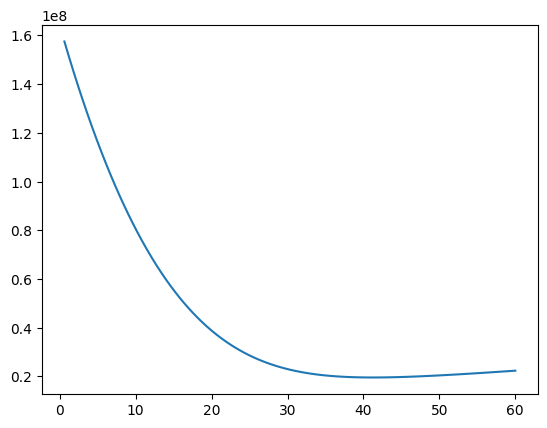

C:\Users\m\AppData\Local\Temp\ipykernel_22476\843756601.py:118: RuntimeWarning: invalid value encountered in cast
  imin = (imin * 255).astype(np.uint8)


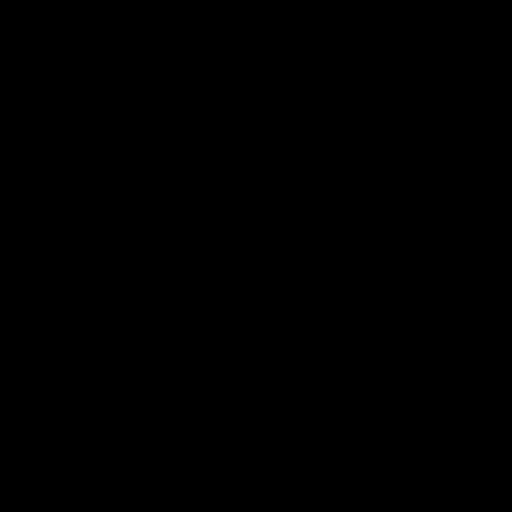

In [80]:
lamda_tab = np.linspace(0,60,100)
erreur_tab_chambolle = [norm2(vartotale_Chambolle(imb,lamda)-im)**2 for lamda in lamda_tab]
lamda_chambolle = lamda_tab[np.argmin(erreur_tab_chambolle)]
erreur_chambolle = np.min(erreur_tab_chambolle)
u_chambolle = vartotale_Chambolle(imb,lamda_chambolle)
print('Meilleur lamdbda CHAMBOLLE :', lamda_chambolle)

plt.plot(lamda_tab, erreur_tab_chambolle)
plt.scatter(lamda_chambolle,erreur_chambolle)
plt.show()
viewimage(u_chambolle)

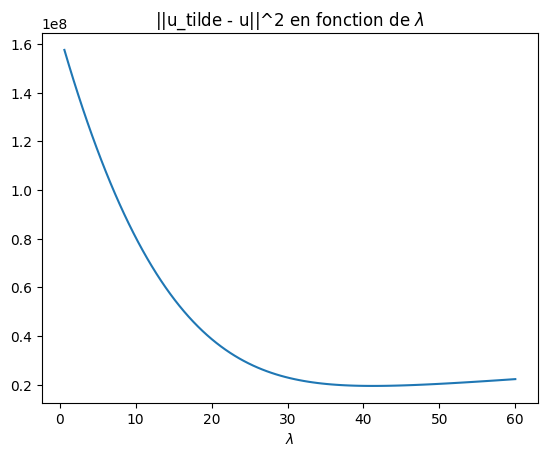

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\m\AppData\Local\Temp\ipykernel_22476\843756601.py:118: RuntimeWarning: invalid value encountered in cast
  imin = (imin * 255).astype(np.uint8)


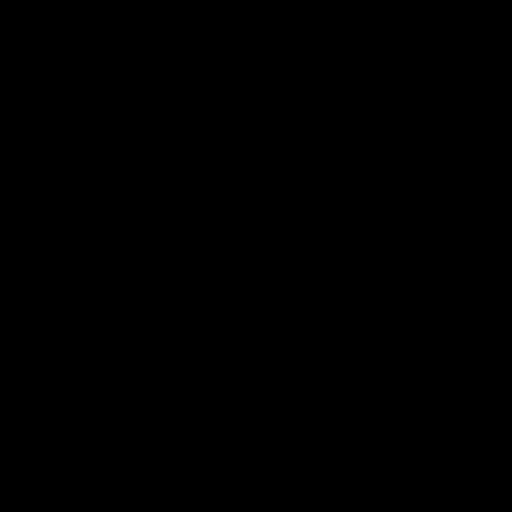

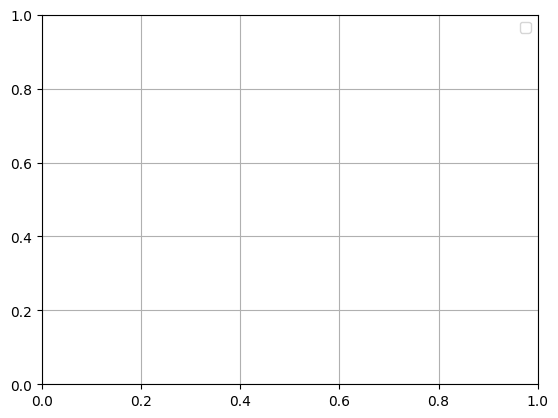

In [86]:
plt.plot(lamda_tab, erreur_tab_chambolle)
plt.scatter(lamda_chambolle,erreur_chambolle,c='r')
plt.title(r'||u_tilde - u||^2 en fonction de $\lambda$')
plt.xlabel(r'$\lambda$')
plt.show()

viewimage(u_chambolle)